# Предсказание стоимости автомобилей

Наш заказчик, сервис по продаже автомобилей, просит нас построить модель для предсказания рыночной стоимости автомобилей.

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install lightgbm -q
!pip install phik -q
!pip install missingno -q
!pip install feature_engine -q

# Импортируем основные библиотеки для работы
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import time
import os
import sys
import missingno as msno

# Импортируем модели, метрики, вспомогательные инструменты и функции
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from lightgbm import LGBMRegressor
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder, RareLabelEncoder, OrdinalEncoder
from feature_engine.selection import DropFeatures

# warnings.filterwarnings("ignore", category=FutureWarning) 

# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
#     os.environ["PYTHONWARNINGS"] = "ignore"

pd.set_option('display.max_columns', None)

random_state = 42

n_cpus = os.cpu_count()
n_jobs = n_cpus - 1


## Подготовка данных

### Изучение основной информации о датасете

Откроем файл и сохраним его в переменной `df`, получим основную информацию с помощью метода .info() и построим гистограммы для всех признаков датасета.

In [2]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Признаки**:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


**Целевой признак**:
- Price — цена (евро)

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


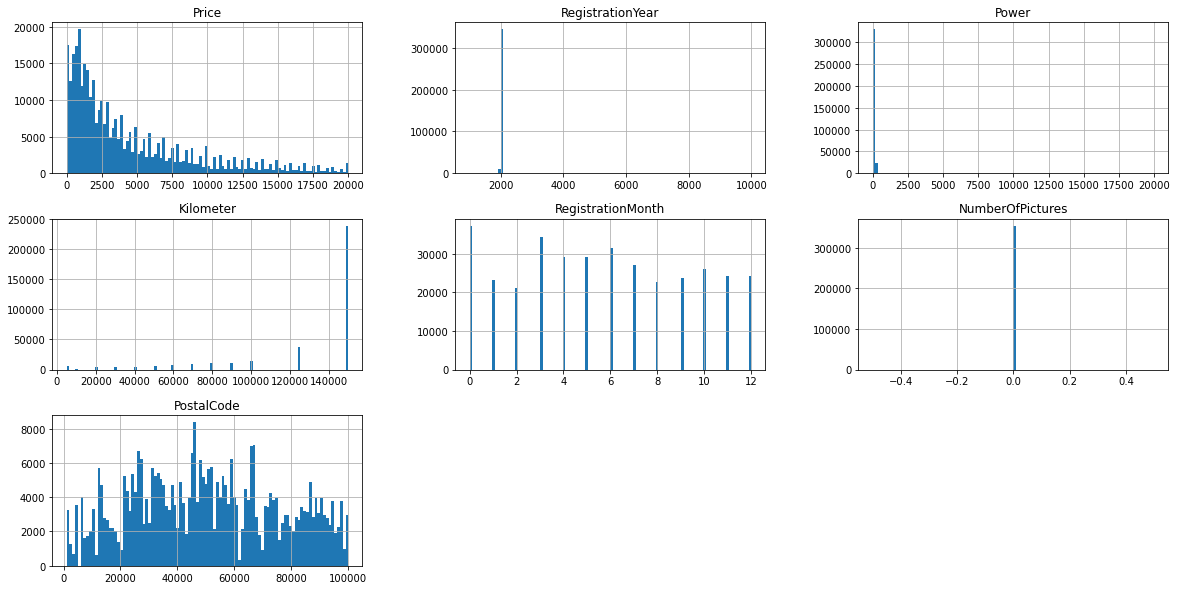

In [5]:
df.hist(figsize=(20, 10), bins=100)
plt.show()

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


---
**Вывод:** изучив основную информацию о датасете, можно утверждать, что
- названия стоблцов приведем к нижнему регистру - для удобства;
- в данных присутствуют пропуски - изучим их подробнее;
- на всякий случай имеет смысл проверить данные на дубликаты;
- в данных присутствуют аномалии - год регистрации - 1000 и 9999, количество л.с. - 9999 и 0, цена - 0; необходимо будет их обработать;
- необходимо будет изучить категориальные признаки на уникальность подробнее - категориальные признаки, доля значений которых будет меньше 1% от общего количества строк, мы заменим на "rare";
- столбцы "DateCrawled", "RegistrationMonth", "DateCreated", "NumberOfPictures", "PostalCode", "LastSeen" необходимо будет отбросить - они не несут прогностического смысла для обучения наших моделей; 
- необходимо проверить данные на мультиколлинеарность;
- данные не стандартизированы - исправим это на preprocessing-шаге pipeline'ов наших моделей;
- категориальные признаки будут закодированы методом OHE на preprocessing-шаге pipeline'ов наших моделей.

### Изменение названий столбцов

Приведем названия столбцов к нижнему регистру.

In [7]:
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

### Изучение пропусков

Построим barplot и матрицу пропусков - для наглядности.

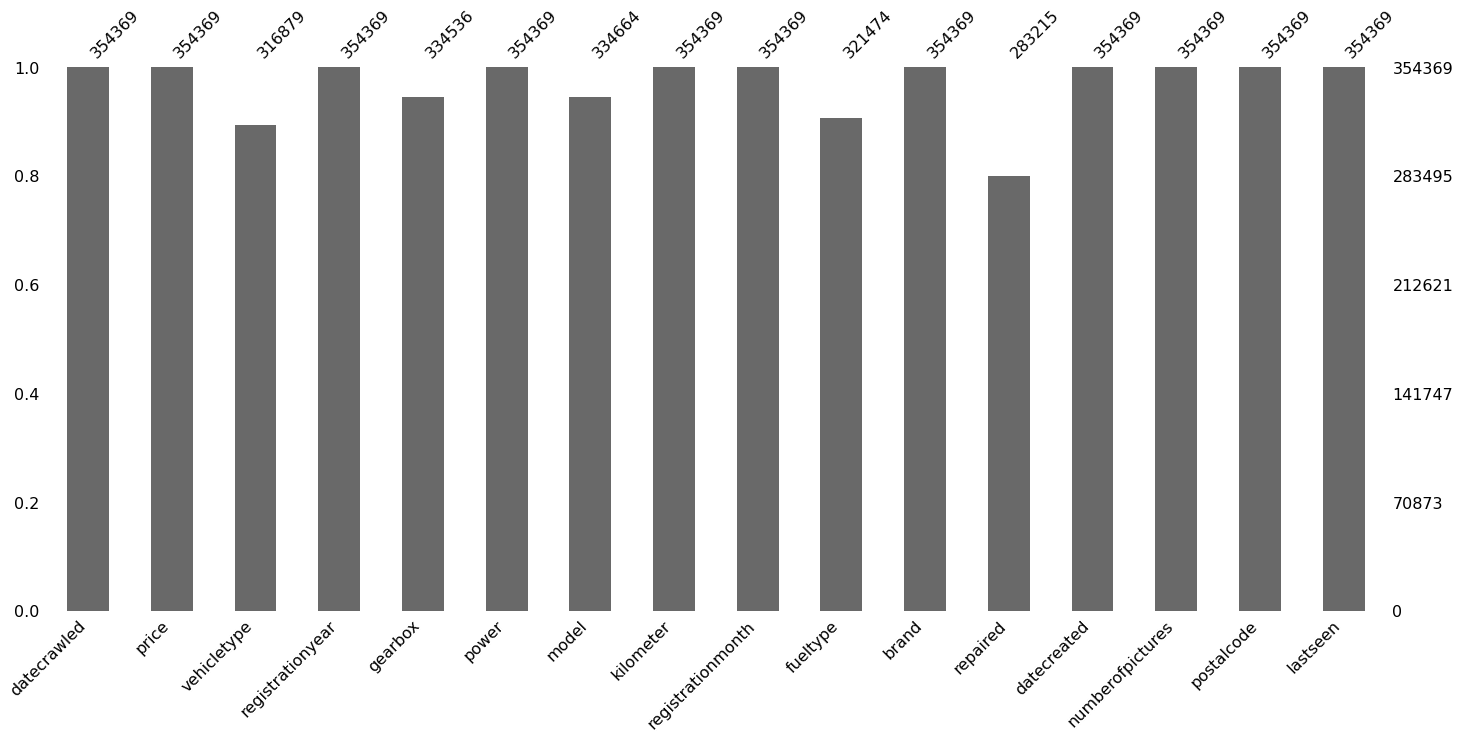

In [8]:
msno.bar(df)
plt.show()

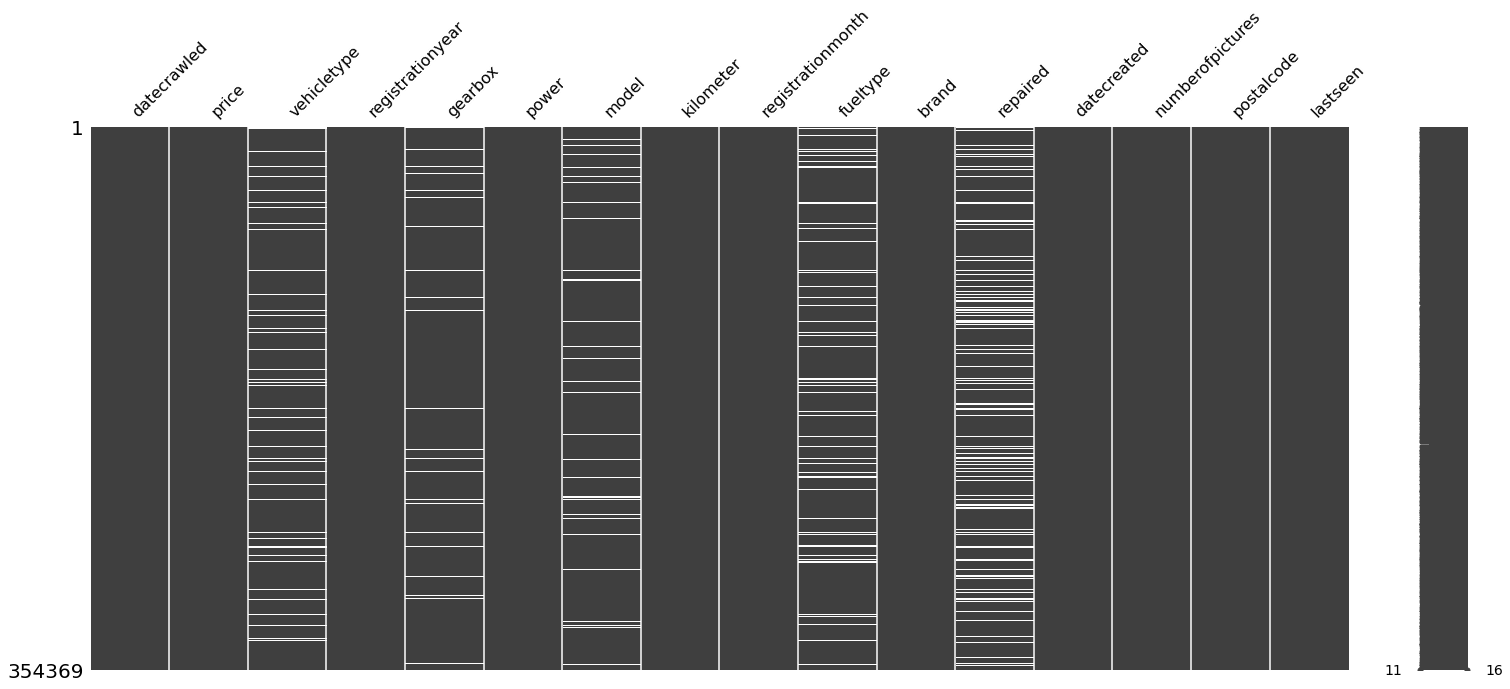

In [9]:
msno.matrix(df)
plt.show()

Построим тепловую карту корреляции пропусков:

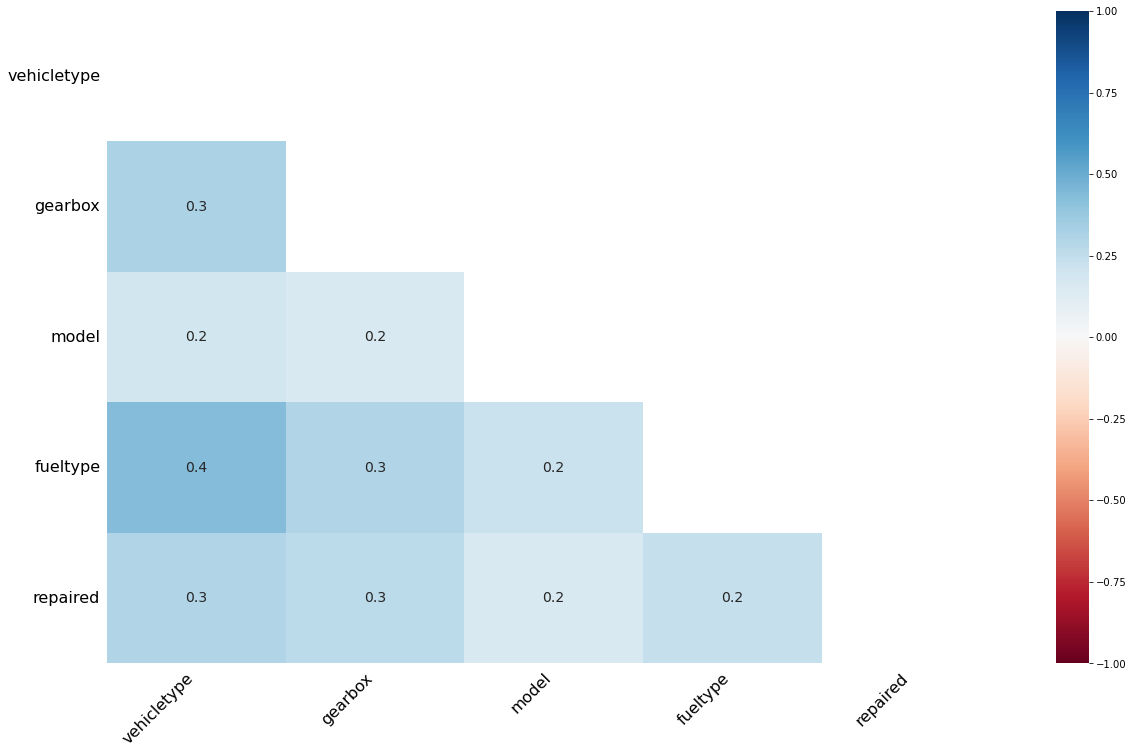

In [10]:
msno.heatmap(df)
plt.show()

In [11]:
df.isna().sum()/df.shape[0]

datecrawled          0.000000
price                0.000000
vehicletype          0.105794
registrationyear     0.000000
gearbox              0.055967
power                0.000000
model                0.055606
kilometer            0.000000
registrationmonth    0.000000
fueltype             0.092827
brand                0.000000
repaired             0.200791
datecreated          0.000000
numberofpictures     0.000000
postalcode           0.000000
lastseen             0.000000
dtype: float64

Как мы видим, пропуски есть в стоблцах "vehicletype", "gearbox", "model", "fueltype" и "repaired". Во всех случаях пропусков больше 5%. Корректнее всего будет заменить пропуски значением "missing" - т.к. мы не можем с твёрдой уверенностью заполнить пропуски иными значениями. Мы будем заполнять пропуски в ходе preprocessing-шага наших пайплайнов.

### Поиск дубликатов

Проведём поиск явных дубликатов. Удалим их.

In [12]:
df.duplicated().sum()

4

In [13]:
print(f'Количество строк до удаления дубликатов: {df.shape[0]}')
df = df.drop_duplicates()
print(f'Количество строк после удаления дубликатов: {df.shape[0]}')

Количество строк до удаления дубликатов: 354369
Количество строк после удаления дубликатов: 354365


Проведём поиск неявных дубликатов - изучим уникальные значения категориальных переменных.

In [14]:
unique_cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

for cat in unique_cat_features:
    print(f'Признак {cat} \n')
    print(sorted(df[cat].dropna().unique()), '\n\n')

Признак vehicletype 

['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon'] 


Признак gearbox 

['auto', 'manual'] 


Признак model 

['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster

Неявных дубликатов нет.

### Удаление аномалий

Изучим подробнее аномалии (года регистрации - 1000 и 9999, количество л.с. - 9999 и 0, цена ~ 0).

In [15]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [16]:
df[df['registrationyear'] > 2016].head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37


In [17]:
# Доля строк с регистрацией автомобиля > 2016
df[df['registrationyear'] > 2016].shape[0] / df.shape[0]

0.041002920717339464

In [18]:
df[df['registrationyear'] < 1910].head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
18224,2016-03-09 17:49:44,7999,NaN,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
34332,2016-04-01 06:02:10,450,NaN,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,2016-04-01 00:00:00,0,63322,2016-04-01 09:42:30
38875,2016-03-19 23:54:40,1234,NaN,1234,NaN,26,NaN,5000,1,NaN,trabant,NaN,2016-03-19 00:00:00,0,38518,2016-04-06 03:15:22


In [19]:
# Доля строк с регистрацией автомобиля < 1910
df[df['registrationyear'] < 1910].shape[0] / df.shape[0]

0.00018624864193698588

In [20]:
df[df['power'] > 2000].head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
11039,2016-03-25 19:55:32,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25 00:00:00,0,57520,2016-04-01 19:16:33
19092,2016-03-20 17:54:04,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no,2016-03-20 00:00:00,0,21376,2016-03-23 02:48:53
25232,2016-03-28 19:57:39,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no,2016-03-28 00:00:00,0,36272,2016-04-07 02:47:02
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,NaN,toyota,no,2016-03-09 00:00:00,0,94116,2016-03-17 05:16:32


In [21]:
# Доля строк с мощностью > 2000 л.с.
df[df['power'] > 2000].shape[0] / df.shape[0]

0.00033863389443088344

In [22]:
df[df['power'] == 0].head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34


In [23]:
# Доля строк с мощностью = 0 л.с.
df[df['power'] == 0].shape[0] / df.shape[0]

0.11351290336235238

In [24]:
# Доля строк с ценой = 0 
df[df['price'] == 0].shape[0] / df.shape[0]

0.030398035923412302

Итак, нам необходимо избавиться от строк:
- год регистрации > 2016 (т.к. данные скачивались из базы в 2016 году - всё что позднее зарегистрировано - явная аномалия) - 4% строк;
- год регистрации < 1910 - 0.02% строк;
- количество л.с > 2000 - 0.03% строк;
- цена = 0 - 3% строк.

И обработать аномалии:
- количество л.с. = 0 - 11% строк.

In [25]:
print(f'Количество строк до удаления аномалий: {df.shape[0]}')
df = (
    df[
        (df['registrationyear'] <= 2016) &
        (df['registrationyear'] >= 1910) &
        (df['power'] <= 2000) &
        (df['price'] > 0)]
)
print(f'Количество строк после удаления аномалий: {df.shape[0]}')

Количество строк до удаления аномалий: 354365
Количество строк после удаления аномалий: 329658


Обрабатывать аномалии "количество л.с. = 0" мы будем так:
- присвоим всем нулевым значениям "NaN";
- заполним все NaN-значения средними значениями по группировкам "год регистрации - модель" (при этом нулевых значений уже нет, значит они не будут вносить никакой доли в средние значения);
- обрезать оставшиеся NaN, если таковые найдутся.

In [26]:
# Исходная доля строк с нулевой мощностью
df[df['power'] == 0].shape[0] / df.shape[0]

0.09969726201093254

In [27]:
df.loc[df['power'] == 0, 'power'] = float('NaN')
df['power'] = df['power'].fillna(df.groupby(['registrationyear', 'model'])['power'].transform('mean'))

In [28]:
# Доля строк с NaN мощностью после заполнения средним по группе
df['power'].isna().sum() / df.shape[0]

0.014202597843826026

In [29]:
# Удаляем строки с "power = NaN"
df = df.dropna(subset=['power'])

Отлично, часть аномалий удалена, часть - обработана.

### Изучение категориальных признаков

Изучим подробнее категориальные признаки - найдём значения признаков, доля которых меньше 1% и больше 1%.

In [30]:
def find_rare_labels(df, var, rare_perc):
    """
    Находим редкие лейблы, доля которых меньше rare_perc
    """

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp < rare_perc].index


def find_frequent_labels(df, var, rare_perc):
    """
    Находим популярные лейблы, доля которых больше rare_perc
    """

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index

In [31]:
# Найдём редкие лейблы, доля которых меньше 1%

cat_rare = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

for var in cat_rare:
    
    frequent_ls = find_rare_labels(df, var, 0.01)
    
    print(f'Признак {var} \n {frequent_ls} \n\n')
    

Признак vehicletype 
 Index(['other'], dtype='object', name='vehicletype') 


Признак gearbox 
 Index([], dtype='object', name='gearbox') 


Признак model 
 Index(['100', '145', '147', '156', '159', '1_reihe', '200', '300c', '4_reihe',
       '500',
       ...
       'wrangler', 'x_reihe', 'x_trail', 'x_type', 'xc_reihe', 'yaris', 'yeti',
       'ypsilon', 'z_reihe', 'zafira'],
      dtype='object', name='model', length=224) 


Признак fueltype 
 Index(['cng', 'electric', 'hybrid', 'other'], dtype='object', name='fueltype') 


Признак brand 
 Index(['alfa_romeo', 'chevrolet', 'chrysler', 'dacia', 'daewoo', 'daihatsu',
       'honda', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover',
       'mini', 'mitsubishi', 'porsche', 'rover', 'saab', 'sonstige_autos',
       'subaru', 'suzuki', 'trabant', 'volvo'],
      dtype='object', name='brand') 


Признак repaired 
 Index([], dtype='object', name='repaired') 




In [32]:
# Найдём популярные лейблы, доля которых больше 1%

for var in cat_rare:
    
    frequent_ls = find_frequent_labels(df, var, 0.01)
    
    print(f'Признак {var} \n {frequent_ls} \n\n')
    

Признак vehicletype 
 Index(['bus', 'convertible', 'coupe', 'sedan', 'small', 'suv', 'wagon'], dtype='object', name='vehicletype') 


Признак gearbox 
 Index(['auto', 'manual'], dtype='object', name='gearbox') 


Признак model 
 Index(['1er', '2_reihe', '3_reihe', '3er', '5er', 'a3', 'a4', 'a6', 'a_klasse',
       'astra', 'c_klasse', 'clio', 'corsa', 'e_klasse', 'fiesta', 'focus',
       'fortwo', 'golf', 'mondeo', 'other', 'passat', 'polo', 'transporter',
       'twingo', 'vectra'],
      dtype='object', name='model') 


Признак fueltype 
 Index(['gasoline', 'lpg', 'petrol'], dtype='object', name='fueltype') 


Признак brand 
 Index(['audi', 'bmw', 'citroen', 'fiat', 'ford', 'hyundai', 'mazda',
       'mercedes_benz', 'nissan', 'opel', 'peugeot', 'renault', 'seat',
       'skoda', 'smart', 'toyota', 'volkswagen'],
      dtype='object', name='brand') 


Признак repaired 
 Index(['no', 'yes'], dtype='object', name='repaired') 




Вот что мы будем делать с редкими лейблами - в ходе preprocessing-шага наших пайплайнов мы будем кодировать их в единую группу "rare" - это должно улучшить качество наших моделей. Порог для кодирования будет составлять 1%.

### Удаление лишних признаков

Мы будем удалять лишние признаки "datecrawled", "registrationmonth", "datecreated", "numberofpictures", "postalcode", "lastseen" (данные признаки не несут никакой прогностической силы для наших моделей) в ходе preprocessing-шага наших пайплайнов.

### Корреляция признаков

Взглянем на тепловую карту корреляций Пирсона наших признаков.

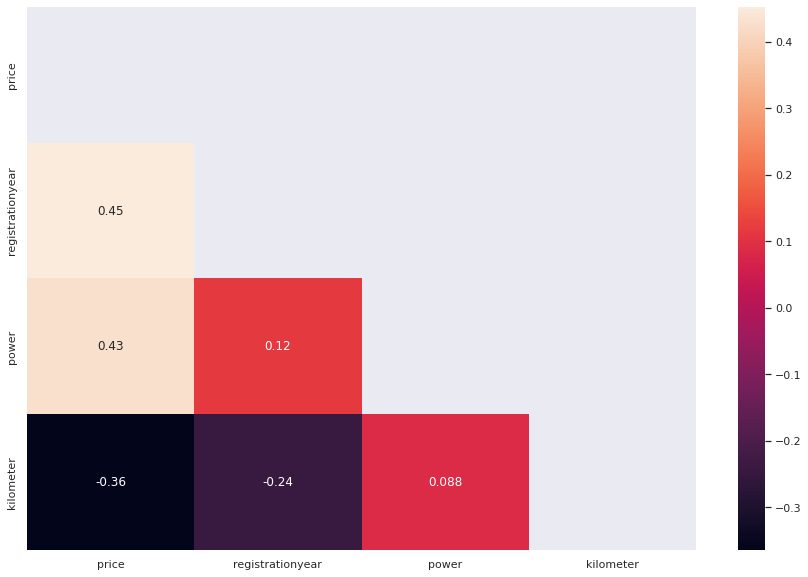

In [33]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(
    df[['price', 'registrationyear', 'power', 'kilometer']].corr(),
    annot=True,
    mask=np.triu(np.ones_like(df[['price', 'registrationyear', 'power', 'kilometer']].corr()))
)
plt.show()

Как мы видим, сильных (>0.8) корреляций между признаками нет, проблема мультиколлинеарности в данных не стоит.

Дополнительно взглянем на phik-корреляцию между признаками:

In [34]:
features_for_phik = [
    'price',
    'vehicletype',
    'registrationyear',
    'gearbox',
    'power',
    'model',
    'kilometer',
    'registrationmonth',
    'fueltype',
    'brand',
    'repaired'
]

phik_overview = df[features_for_phik].phik_matrix()
significance_overview = df[features_for_phik].significance_matrix()

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth']
interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth']


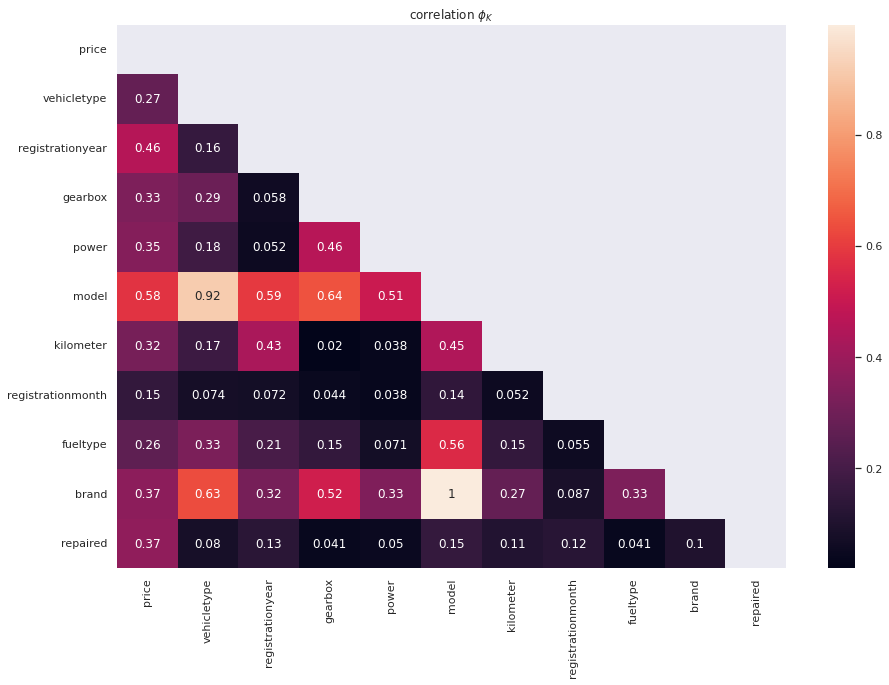

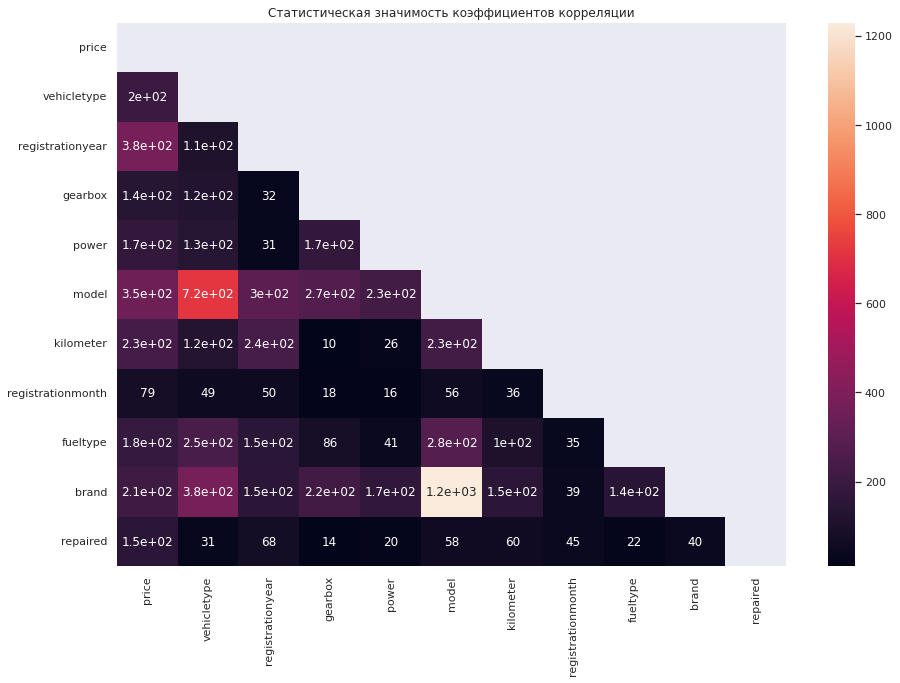

In [35]:
sns.heatmap(
    phik_overview,
    annot=True,
    mask=np.triu(np.ones_like(phik_overview))
)
plt.title(r'correlation $\phi_K$')
plt.show()

sns.heatmap(
    significance_overview,
    annot=True,
    mask=np.triu(np.ones_like(significance_overview))
)
plt.title('Статистическая значимость коэффициентов корреляции')
plt.show()

Нас не должны смущать высокие значения phik-корреляции, поскольку сама мультиколлинеарность определена как наличие **линейных** взаимосвязей; важно для линейной модели в любом случае проверять именно линейные взаимосвязи, т.е. корреляцию Пирсона.

In [36]:
#КОД РЕВЬЮЕРА

df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,324976.000000,324976.000000,324976.000000,324976.000000,324976.000000,324976.0,324976.000000
mean,4641.700246,2002.663541,120.359387,128433.330461,5.864476,0.0,50841.664341
std,4552.709408,6.729625,61.882560,37143.660928,3.657991,0.0,25758.741855
min,1.000000,1910.000000,1.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30519.000000
50%,2950.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,49681.000000
75%,6700.000000,2007.000000,147.000000,150000.000000,9.000000,0.0,71394.000000
max,20000.000000,2016.000000,2000.000000,150000.000000,12.000000,0.0,99998.000000


### Разбиение данных на выборки.

Разобьём данные на обучающую и тестовую выборки (мы будем применять кросс-валидацию, поэтому валидационная выборка включена в обучающую) в соотношении 9:1, т.к. у нас достаточно большой набор данных и нам выгоднее максимально увеличить объем обучающей выборки.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['price'], axis=1), # признаки
    df['price'], # таргет
    test_size=0.1,
    random_state=random_state,
)

X_train.shape, X_test.shape

((292478, 15), (32498, 15))

---
**Вывод:** завершив этап подготовки данных, мы
- привели названия столбцов к единому формату - для удобства;
- изучили пропуски - они есть в стоблцах "vehicletype", "gearbox", "model", "fueltype" и "repaired". Во всех случаях пропусков больше 5%. Корректнее всего будет заменить пропуски значением "missing" - т.к. мы не можем с твёрдой уверенностью заполнить пропуски иными значениями. Мы будем заполнять пропуски в ходе preprocessing-шага наших пайплайнов;
- нашли и удалили явные дубликаты; неявных дубликатов не обнаружено;
- нашли и удалили аномалии (год регистрации > 2016, год регистрации < 1910, количество л.с > 2000, цена = 0); мы обработали аномалии "количество л.с. = 0", заменив такие значения средними значениями из группировки "год регистрации - модель";
- приняли решение кодировать редкие лейблы признаков (доля < 1%) в группу "rare" в ходе preprocessing-шага наших пайплайнов;
- приняли решение удалять лишние признаки "datecrawled", "registrationmonth", "datecreated", "numberofpictures", "postalcode", "lastseen" (данные признаки не несут никакой прогностической силы для наших моделей) в ходе preprocessing-шага наших пайплайнов;
- проверили данные на мультиколлинеарность - данной проблемы не стоит в наших данных;
- разбили данные на обучающую и тестовую выборку в соотношении 9 к 1; мы будем применять кросс-валидацию.

## Обучение моделей

### Подготовка preprocessing-шага для pipeline'ов

Подготовим preprocessing-шаг для наших pipeline'ов.

В preprocessing-шаге мы будем:
1) заполнять пропуски значением "missing";

2) группировать у категориальных признаков редкие лейблы (доля < 1%) в группу "rare";

3) производить OHE для категориальных признаков;

4) удалять лишние признаки;

5) стандартизировать все числовые признаки.

В последующих pipeline'ах мы будем постоянно использовать этот шаг.

In [38]:
CATEGORICAL_VARS_TO_DROP = [ # Признаки, которые мы будем удалять
    'datecrawled',
    'registrationmonth',
    'datecreated',
    'numberofpictures',
    'postalcode',
    'lastseen']

CATEGORICAL_VARS_WITH_NA = [ # Признаки с пропусками
    'vehicletype',
    'gearbox',
    'model',
    'fueltype',
    'repaired'
]

CATEGORICAL_VARS_WITH_RARE_LABELS = [ # Признаки для группировки редких лейблов
    'model',
    'fueltype',
    'brand'
]

CATEGORICAL_VARS_FOR_OHE = [ # Признаки для OHE
    'vehicletype',
    'gearbox',
    'fueltype',
    'repaired'
]

CATEGORICAL_VARS_FOR_OHE_OR_ORDINAL = [ # Признаки для OHE или OrdinalEncoding
    'model',
    'brand'
]

NUMERICAL_VARS = [ # Числовые признаки
    'registrationyear',
    'power',
    'kilometer'
]

In [39]:
preprocessor = Pipeline([

    # ===== Замена пропусков =====
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA)),
    
    # === Кодирование редких лейблов ===
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS_WITH_RARE_LABELS
    )),
    
    # === Кодирование OHE для категориальных признаков ===
    ('one_hot_encoder', OneHotEncoder(
        variables=CATEGORICAL_VARS_FOR_OHE+CATEGORICAL_VARS_FOR_OHE_OR_ORDINAL)),
    
    # == Удаление лишних признаков ====
    ('drop_features', DropFeatures(features_to_drop=CATEGORICAL_VARS_TO_DROP)),
    
    # == Стандартизация ====
    ('standard_scaler', StandardScaler())
])

### Построение моделей

Мы построим 3 модели:
- линейную регрессию с L2-регуляризацией (ridge-регрессию);
- градиентный бустинг LGBM;
- случайный лес.

Все модели мы будем строить с кросс-валидацией в 8 фолдов.

In [40]:
# Для сводной таблицы
model = []
score = []
fit_time = []
predict_time = []

#### Ridge-регрессия

In [41]:
%%time

lr_pipe = Pipeline(steps=[ # Строим пайплайн с препроцессором
        ('preprocessor', preprocessor),
        ('model', Ridge())
])

parameter_space = { # Задаём пространство гиперпараметров
        'model__alpha'       : [1,50],
        'model__solver'  : ['lsqr', 'saga'],
        'model__random_state' : [random_state]
}

# Инициализируем поиск по решётке нашего пайплайна
lr_grid = GridSearchCV(lr_pipe, parameter_space, scoring='neg_root_mean_squared_error', cv=8, n_jobs=4)

lr_grid.fit(X_train, y_train) # Обучаем модель

best_lr = lr_grid.best_estimator_ # Для просмотра гиперпараметров модели
best_rmse_lr = lr_grid.best_score_ # Лучший скор модели

CPU times: user 27.9 s, sys: 4.76 s, total: 32.6 s
Wall time: 1min 40s


In [42]:
results = pd.DataFrame(lr_grid.cv_results_) # Сохраняем результаты GridSearchCV во временную переменную
fit_time_lr = results[results['rank_test_score'] == 1]['mean_fit_time'].values[0] # Время обучения лучшей модели
predict_time_lr = results[results['rank_test_score'] == 1]['mean_score_time'].values[0] # Время предсказания

model.append('Ridge regression')
score.append(-best_rmse_lr)
fit_time.append(fit_time_lr)
predict_time.append(predict_time_lr)

print(f'Лучшая модель ridge-регресии показала RMSE: {-best_rmse_lr}.')
print(f'Гиперпараметры:')
best_lr

Лучшая модель ridge-регресии показала RMSE: 2888.8120437145876.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('missing_imputation',
                                  CategoricalImputer(variables=['vehicletype',
                                                                'gearbox',
                                                                'model',
                                                                'fueltype',
                                                                'repaired'])),
                                 ('rare_label_encoder',
                                  RareLabelEncoder(n_categories=1, tol=0.01,
                                                   variables=['model',
                                                              'fueltype',
                                                              'brand'])),
                                 ('one_hot_encoder',
                                  OneHotEncoder(variables=['vehicletype',
                                                           'gearbox',
                                                           'fueltype',
                                                           'repaired', 'model',
                                                           'brand'])),
                                 ('drop_features',
                                  DropFeatures(features_to_drop=['datecrawled',
                                                                 'registrationmonth',
                                                                 'datecreated',
                                                                 'numberofpictures',
                                                                 'postalcode',
                                                                 'lastseen'])),
                                 ('standard_scaler', StandardScaler())])),
                ('model', Ridge(alpha=50, random_state=42, solver='lsqr'))])

#### Градиентный бустинг

In [43]:
%%time

lgbm_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LGBMRegressor())
])

parameter_space = {
    'model__boosting_type' : ['gbdt'], 
    'model__max_depth'     : [4,6],
    'model__n_estimators'  : [70, 150],
    'model__random_state' : [random_state]
}

lgbm_grid = GridSearchCV(lgbm_pipe, parameter_space, scoring='neg_root_mean_squared_error', cv=8, n_jobs=4)

lgbm_grid.fit(X_train, y_train)

best_lgbm = lgbm_grid.best_estimator_
best_rmse_lgbm = lgbm_grid.best_score_

CPU times: user 52.5 s, sys: 5.67 s, total: 58.1 s
Wall time: 1min 41s


In [44]:
results = pd.DataFrame(lgbm_grid.cv_results_) 
fit_time_lgbm = results[results['rank_test_score'] == 1]['mean_fit_time'].values[0] 
predict_time_lgbm = results[results['rank_test_score'] == 1]['mean_score_time'].values[0] 

model.append('LGBM')
score.append(-best_rmse_lgbm)
fit_time.append(fit_time_lgbm)
predict_time.append(predict_time_lgbm)

print(f'Лучшая модель градиентного бустинга показала RMSE: {-best_rmse_lgbm}.')
print(f'Гиперпараметры:')
best_lgbm

Лучшая модель градиентного бустинга показала RMSE: 1711.5091179010124.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('missing_imputation',
                                  CategoricalImputer(variables=['vehicletype',
                                                                'gearbox',
                                                                'model',
                                                                'fueltype',
                                                                'repaired'])),
                                 ('rare_label_encoder',
                                  RareLabelEncoder(n_categories=1, tol=0.01,
                                                   variables=['model',
                                                              'fueltype',
                                                              'brand'])),
                                 ('one_hot_encoder',
                                  OneHotEncoder(variables=['vehicletype',
                                                           'gearbox',
                                                           'fueltype',
                                                           'repaired', 'model',
                                                           'brand'])),
                                 ('drop_features',
                                  DropFeatures(features_to_drop=['datecrawled',
                                                                 'registrationmonth',
                                                                 'datecreated',
                                                                 'numberofpictures',
                                                                 'postalcode',
                                                                 'lastseen'])),
                                 ('standard_scaler', StandardScaler())])),
                ('model',
                 LGBMRegressor(max_depth=6, n_estimators=150,
                               random_state=42))])

#### Случайный лес

In [45]:
%%time

rfr_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
])

parameter_space = {
    'model__n_estimators' : [100], 
    'model__max_depth'     : [7, 10],
    'model__random_state' : [random_state]
}

rfr_grid = GridSearchCV(rfr_pipe, parameter_space, scoring='neg_root_mean_squared_error', cv=8, n_jobs=4)

rfr_grid.fit(X_train, y_train)

best_rfr = rfr_grid.best_estimator_
best_rmse_rfr = rfr_grid.best_score_

CPU times: user 2min 7s, sys: 2.5 s, total: 2min 10s
Wall time: 15min 38s


In [46]:
results = pd.DataFrame(rfr_grid.cv_results_) 
fit_time_rfr = results[results['rank_test_score'] == 1]['mean_fit_time'].values[0] 
predict_time_rfr = results[results['rank_test_score'] == 1]['mean_score_time'].values[0] 

model.append('Random forest regressor')
score.append(-best_rmse_rfr)
fit_time.append(fit_time_rfr)
predict_time.append(predict_time_rfr)

print(f'Лучшая модель случайного леса показала RMSE: {-best_rmse_rfr}.')
print(f'Гиперпараметры:')
best_rfr

Лучшая модель случайного леса показала RMSE: 1909.8568006250237.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('missing_imputation',
                                  CategoricalImputer(variables=['vehicletype',
                                                                'gearbox',
                                                                'model',
                                                                'fueltype',
                                                                'repaired'])),
                                 ('rare_label_encoder',
                                  RareLabelEncoder(n_categories=1, tol=0.01,
                                                   variables=['model',
                                                              'fueltype',
                                                              'brand'])),
                                 ('one_hot_encoder',
                                  OneHotEncoder(variables=['vehicletype',
                                                           'gearbox',
                                                           'fueltype',
                                                           'repaired', 'model',
                                                           'brand'])),
                                 ('drop_features',
                                  DropFeatures(features_to_drop=['datecrawled',
                                                                 'registrationmonth',
                                                                 'datecreated',
                                                                 'numberofpictures',
                                                                 'postalcode',
                                                                 'lastseen'])),
                                 ('standard_scaler', StandardScaler())])),
                ('model',
                 RandomForestRegressor(max_depth=10, random_state=42))])

---
**Вывод:** завершив этап обучения моделей, мы
- подготовили preprocessing-шаг для пайплайнов наших моделей, включающий в себя: заполнение пропусков, группировку редких лейблов, OHE-кодирование, удаление лишних признаков и стандартизацию;
- обучили модели с кросс-валидацией в 8 фолдов: ridge-регрессию, градиентный бустинг LGBM и случайный лес;
- собрали необходимые статистики для дальнейшего анализа моделей.

## Анализ моделей

### Выбор моделей

Посмотрим на результаты наших моделей, выберем лучшие.

In [47]:
models_dict = {'model' : model, 'score' : score, 'fit_time' : fit_time, 'predict_time' : predict_time}
models_results = pd.DataFrame(models_dict)
models_results

,model,score,fit_time,predict_time
0,Ridge regression,2888.812044,9.307218,0.720481
1,LGBM,1711.509118,11.054766,0.805438
2,Random forest regressor,1909.856801,236.322226,0.931934


Лучшие результаты RMSE показал градиентный бустинг, а по скорости обучения и предсказания он почти идентичен ridge-регрессии. Случайный лес показал неплохой результат RMSE, но самую долгую скорость обучения. Ridge-регрессия не прошла порог в <2500 RMSE.

**Выбираем градиентный бустинг LGBM.**

### Расчёт RMSE на тестовом наборе данных

Рассчитаем RMSE на тестовом наборе данных для модели градиентного бустинга.

In [48]:
predictions_lgbm = lgbm_grid.predict(X_test)
print('RMSE LGBM-модели для тестового набора данных :',
      mean_squared_error(y_test, predictions_lgbm, squared=False))

RMSE LGBM-модели для тестового набора данных : 1690.7288312152373


---
Построим графики рассеяния, чтобы оценить величины ошибок между предсказаниями и целевыми признаками и точность наших моделей; понять, за счёт чего у нас образуется такая ошибка.

In [49]:
dict_target_predictions = {
    'target' : y_test,
    'predictions' : predictions_lgbm,
    'error' : y_test - predictions_lgbm
}

df_target_predictions = pd.DataFrame(dict_target_predictions)

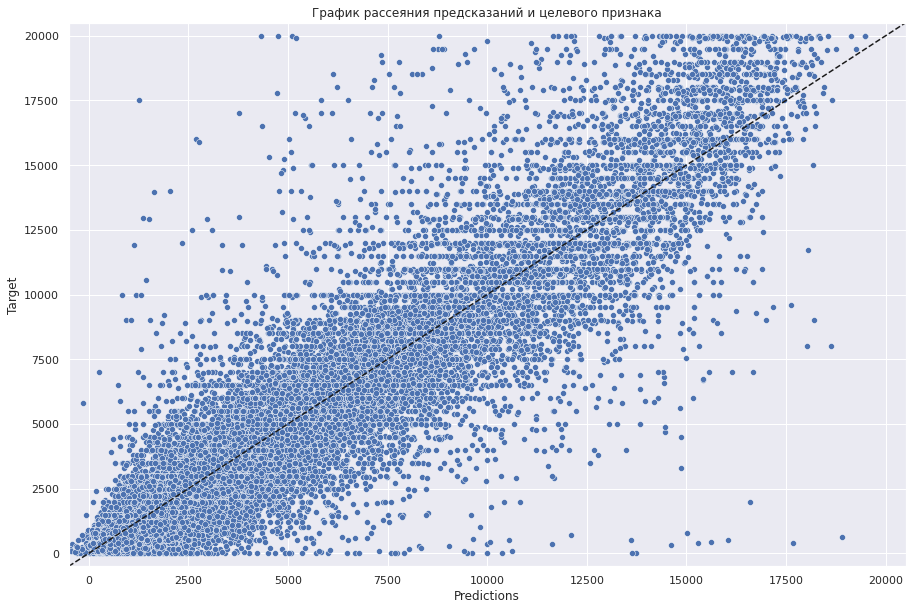

In [50]:
g = sns.scatterplot(data=df_target_predictions, x='predictions', y='target')

g.plot([-500, 20500], [-500, 20500], ls="--", c=".1")
g.set(xlim=(-500, 20500), ylim=(-500, 20500))

plt.title('График рассеяния предсказаний и целевого признака')
plt.xlabel('Predictions')
plt.ylabel('Target')

plt.show()

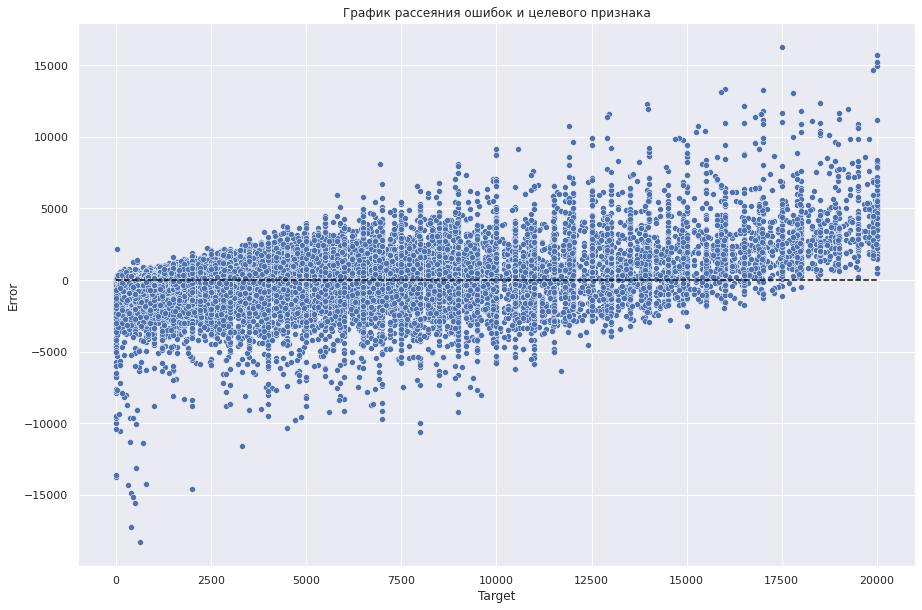

In [51]:
g = sns.scatterplot(data=df_target_predictions, x='target', y='error')

g.plot([0, 20000], [0, 0], ls="--", c=".05")

plt.title('График рассеяния ошибок и целевого признака')
plt.xlabel('Target')
plt.ylabel('Error')

plt.show()

Как мы видим, наша ошибка складывается за счёт ошибочных предсказаний для целевого признака с очень большими и малыми значениями, в целом, у нашей модели приемлемое смещение (bias), но большой разброс (variance).

### Проверка моделей на адекватность

Проверим нашу модель на адекватность - построим модель-пустышку и посчитаем RMSE на тестовом наборе данных.

In [52]:
%%time

dummy_pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

parameter_space = {
    'model__strategy' : ['mean', 'median']
}

dummy_grid = GridSearchCV(dummy_pipe, parameter_space, scoring='neg_root_mean_squared_error', cv=8, n_jobs=4)

dummy_grid.fit(X_train, y_train)

CPU times: user 13 s, sys: 2.34 s, total: 15.3 s
Wall time: 34.5 s


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('missing_imputation',
                                                         CategoricalImputer(variables=['vehicletype',
                                                                                       'gearbox',
                                                                                       'model',
                                                                                       'fueltype',
                                                                                       'repaired'])),
                                                        ('rare_label_encoder',
                                                         RareLabelEncoder(n_categories=1,
                                                                          tol=0.01,
                                                                          variables=['model',
                                                                                     'fueltype',
                                                                                     'brand'])),
                                                        ('one_hot_encoder',
                                                         OneHotEncoder(variables=['vehicletype',
                                                                                  'ge...',
                                                                                  'fueltype',
                                                                                  'repaired',
                                                                                  'model',
                                                                                  'brand'])),
                                                        ('drop_features',
                                                         DropFeatures(features_to_drop=['datecrawled',
                                                                                        'registrationmonth',
                                                                                        'datecreated',
                                                                                        'numberofpictures',
                                                                                        'postalcode',
                                                                                        'lastseen'])),
                                                        ('standard_scaler',
                                                         StandardScaler())])),
                                       ('model', DummyRegressor())]),
             n_jobs=4, param_grid={'model__strategy': ['mean', 'median']},
             scoring='neg_root_mean_squared_error')

In [53]:
predictions_dummy = dummy_grid.predict(X_test)
print('RMSE dummy-модели для тестового набора данных :',
      mean_squared_error(y_test, predictions_dummy, squared=False))

RMSE dummy-модели для тестового набора данных : 4509.27360681721


**RMSE нашего градиентного бустинга почти в 3 раза меньше, чем у пустышки! Наша модель адекватна.**

---
**Вывод:** завершив этап анализа моделей, мы
- сравнили и выбрали модель градиентного бустинга - она показала наименьший RMSE, равный 1711 и хорошую скорость обучения - 11 секунд, время предсказания - 0.8 секунд;
- **рассчитали RMSE на тестовом наборе данных для градиентного бустинга - 1690**;
- проанализировали, из чего складывается ошибка с помощью графиков рассеяния: наша ошибка складывается за счёт ошибочных предсказаний для целевого признака с очень большими и малыми значениями, в целом, у нашей модели приемлемое смещение (bias), но большой разброс (variance).
- проверили нашу модель градиентного бустинга на адекватность - она адекватна, RMSE модели пустышки равно 4509.

## Общий вывод

Отвечая сразу на главный вопрос проекта: мы предлагаем использовать обученную модель градиентного бустинга LGBM, которая показала **RMSE, равное 1690 на тестовом наборе данных** и чья скорость обучения равна всего лишь 11 секундам, а скорость предсказания - 0.8 секунды.

В целом, в ходе проекта:

- завершив этап подготовки данных, мы
    - привели названия столбцов к единому формату - для удобства;
    - изучили пропуски - они есть в стоблцах "vehicletype", "gearbox", "model", "fueltype" и "repaired". Во всех случаях пропусков больше 5%. Корректнее всего будет заменить пропуски значением "missing" - т.к. мы не можем с твёрдой уверенностью заполнить пропуски иными значениями. Мы будем заполнять пропуски в ходе preprocessing-шага наших пайплайнов;
    - нашли и удалили явные дубликаты; неявных дубликатов не обнаружено;
    - нашли и удалили аномалии (год регистрации > 2016, год регистрации < 1910, количество л.с > 2000, цена = 0); мы обработали аномалии "количество л.с. = 0", заменив такие значения средними значениями из группировки "год регистрации - модель";
    - приняли решение кодировать редкие лейблы признаков (доля < 1%) в группу "rare" в ходе preprocessing-шага наших пайплайнов;
    - приняли решение удалять лишние признаки "datecrawled", "registrationmonth", "datecreated", "numberofpictures", "postalcode", "lastseen" (данные признаки не несут никакой прогностической силы для наших моделей) в ходе preprocessing-шага наших пайплайнов;
    - проверили данные на мультиколлинеарность - данной проблемы не стоит в наших данных;
    - разбили данные на обучающую и тестовую выборку в соотношении 9 к 1; мы будем применять кросс-валидацию.
    
    
- завершив этап обучения моделей, мы
    - подготовили preprocessing-шаг для пайплайнов наших моделей, включающий в себя: заполнение пропусков, группировку редких лейблов, OHE-кодирование, удаление лишних признаков и стандартизацию;
    - обучили модели с кросс-валидацией в 8 фолдов: ridge-регрессию, градиентный бустинг LGBM и случайный лес;
    - собрали необходимые статистики для дальнейшего анализа моделей.
    

- завершив этап анализа моделей, мы
    - сравнили и выбрали модель градиентного бустинга - она показала наименьший RMSE, равный 1711 и хорошую скорость обучения - 11 секунд, а время предсказания - 0.8 секунд;
    - **рассчитали RMSE на тестовом наборе данных для градиентного бустинга - 1690**;
    - проанализировали, из чего складывается ошибка с помощью графиков рассеяния: наша ошибка складывается за счёт ошибочных предсказаний для целевого признака с очень большими и малыми значениями, в целом, у нашей модели приемлемое смещение (bias), но большой разброс (variance).
    - проверили нашу модель градиентного бустинга на адекватность - она адекватна, RMSE модели пустышки равно 4509.